# Premier League Match Analysis: A Statistical Exploration

This project analyzes Premier League match results from the 2006-2007 season to the 2023-2024 season. It serves as a portfolio piece to demonstrate a wide array of foundational data analysis skills, from basic statistical concepts to more advanced techniques.

First, we need to import the libraries that we're going to use for analysis.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()

Next, we will go ahead and import the data from our csv file into a Pandas DataFrame

In [2]:
results_df = pd.read_csv("data/results_data.csv")

Now that the data is loaded into a DataFrame we can just take a quick look at what we might be working with. First, we will have Python display some of the basic _info_ of the DataFrame and then we will actually look at the _first 5 rows_ of the DataFrame

In [3]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   home_team   6500 non-null   object
 1   away_team   6500 non-null   object
 2   home_goals  6500 non-null   int64 
 3   away_goals  6500 non-null   int64 
 4   season      6500 non-null   object
dtypes: int64(2), object(3)
memory usage: 254.0+ KB


In [4]:
results_df.head()

,home_team,away_team,home_goals,away_goals,season
0,Sheffield United,Liverpool,1,1,2006-2007
1,Arsenal,Aston Villa,1,1,2006-2007
2,Everton,Watford,2,1,2006-2007
3,Newcastle United,Wigan Athletic,2,1,2006-2007
4,Portsmouth,Blackburn Rovers,3,0,2006-2007


The dataset appears fine. I am a little suspicious of the team names and whether or not they are all spelled correctly. Let's take a look at the unique values that we have for the columns *home_team* *away_team* and *season*.

In [5]:
sorted(results_df.home_team.unique())

['AFC Bournemouth',
 'Arsenal',
 'Aston Villa',
 'Birmingham City',
 'Blackburn Rovers',
 'Blackpool',
 'Bolton Wanderers',
 'Bournemouth',
 'Brentford',
 'Brighton',
 'Brighton & Hove Albion',
 'Brighton and Hove Albion',
 'Burnley',
 'Cardiff',
 'Cardiff City',
 'Charlton Athletic',
 'Chelsea',
 'Crystal Palace',
 'Derby County',
 'Everton',
 'Fulham',
 'Huddersfield',
 'Huddersfield Town',
 'Hull City',
 'Leeds',
 'Leicester',
 'Leicester City',
 'Liverpool',
 'Luton Town',
 'Man City',
 'Man United',
 'Manchester City',
 'Manchester United',
 'Middlesbrough',
 'Newcastle',
 'Newcastle United',
 'Norwich',
 'Norwich City',
 'Nottingham',
 'Nottingham Forest',
 'Portsmouth',
 'Queens Park Rangers',
 'Reading',
 'Sheffield United',
 'Southampton',
 'Stoke City',
 'Sunderland',
 'Swansea City',
 'Tottenham',
 'Tottenham Hotspur',
 'Watford',
 'West Brom',
 'West Bromwich Albion',
 'West Ham',
 'West Ham United',
 'Wigan Athletic',
 'Wolverhampton Wanderers',
 'Wolves']

As I suspected we can already see that our names are going to have issues. For example, in the home_team column we have 3 different versions of the team Brighton & Hove Albion. Let's go ahead and make a list of all the team names from both columns, sort it, and use that list to create a name map for both columns.

In [6]:
team_list = []

for team in results_df.home_team.unique():
    team_list.append(team)

for team in results_df.away_team.unique():
    if team not in team_list:
        team_list.append(team)

team_list.sort()

team_list_length = len(team_list)

print(f"The number of unique team names in this list is: {team_list_length}")

for team in team_list:
    print(team)

The number of unique team names in this list is: 58
AFC Bournemouth
Arsenal
Aston Villa
Birmingham City
Blackburn Rovers
Blackpool
Bolton Wanderers
Bournemouth
Brentford
Brighton
Brighton & Hove Albion
Brighton and Hove Albion
Burnley
Cardiff
Cardiff City
Charlton Athletic
Chelsea
Crystal Palace
Derby County
Everton
Fulham
Huddersfield
Huddersfield Town
Hull City
Leeds
Leicester
Leicester City
Liverpool
Luton Town
Man City
Man United
Manchester City
Manchester United
Middlesbrough
Newcastle
Newcastle United
Norwich
Norwich City
Nottingham
Nottingham Forest
Portsmouth
Queens Park Rangers
Reading
Sheffield United
Southampton
Stoke City
Sunderland
Swansea City
Tottenham
Tottenham Hotspur
Watford
West Brom
West Bromwich Albion
West Ham
West Ham United
Wigan Athletic
Wolverhampton Wanderers
Wolves


I am going to create a dictionary to map all of the variations to standard names. We will simply pick 1 version of a team name and apply it to any variations that might occur in the list.

In [7]:
team_name_mapping = {
    "AFC Bournemouth": "Bournemouth",
    "Brighton": "Brighton and Hove Albion",
    "Brighton & Hove Albion": "Brighton and Hove Albion",
    "Cardiff": "Cardiff City",
    "Huddersfield": "Huddersfield Town",
    "Leicester": "Leicester City",
    "Man City": "Manchester City",
    "Man United": "Manchester United",
    "Newcastle": "Newcastle United",
    "Norwich": "Norwich City",
    "Nottingham": "Nottingham Forest",
    "Tottenham": "Tottenham Hotspur",
    "West Brom": "West Bromwich Albion",
    "West Ham": "West Ham United",
    "Wolves": "Wolverhampton Wanderers"
}

Let's go ahead and apply our mapping and just double check that we captured all of the issues in our columns.

In [8]:
results_df['home_team'] = results_df['home_team'].replace(team_name_mapping)
results_df['away_team'] = results_df['away_team'].replace(team_name_mapping)

In [9]:
team_list = []

for team in results_df.home_team.unique():
    team_list.append(team)

for team in results_df.away_team.unique():
    if team not in team_list:
        team_list.append(team)

team_list.sort()

team_list_length = len(team_list)

print(f"The number of unique team names in this list is: {team_list_length}")

for team in team_list:
    print(team)

The number of unique team names in this list is: 43
Arsenal
Aston Villa
Birmingham City
Blackburn Rovers
Blackpool
Bolton Wanderers
Bournemouth
Brentford
Brighton and Hove Albion
Burnley
Cardiff City
Charlton Athletic
Chelsea
Crystal Palace
Derby County
Everton
Fulham
Huddersfield Town
Hull City
Leeds
Leicester City
Liverpool
Luton Town
Manchester City
Manchester United
Middlesbrough
Newcastle United
Norwich City
Nottingham Forest
Portsmouth
Queens Park Rangers
Reading
Sheffield United
Southampton
Stoke City
Sunderland
Swansea City
Tottenham Hotspur
Watford
West Bromwich Albion
West Ham United
Wigan Athletic
Wolverhampton Wanderers


I think we have taken care of all of the issues with the team names. Lets just take a look at our *season* column and the unique values for that variable.

In [10]:
print(results_df.season.unique())

['2006-2007' '2007-2008' '2008-2009' '2009-2010' '2010-2011' '2011-2012'
 '2012-2013' '2013-2014' '2014-2015' '2015-2016' '2016-2017' '2017-2018'
 '2018-2019' '2019-2020' '2020-2021' '2021-2022' '2022-2023' '2023-2024']


Since we have already shown in a previous step that we have no null values and soccer matches are allowed to have 0 goals scored I will not check the home_goals and away_goals columns. This is for 2 reasons. One, if the data has no values that are specifically labled null or left blank, and a team is allowed to score 0 goals in a game, we cannot assume that a 0 means that the data is missing or null. Two, we will be later looking at the distribution of this data and getting an idea for it's shape and potential outliers. So we can leave these alone for now.

Next, let's just make sure that the DataFrame data types are exactly how we want them to be for analysis. Let's go ahead and change the *home_team*, *away_team*, and *season* to the categorical data type.

In [11]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   home_team   6500 non-null   object
 1   away_team   6500 non-null   object
 2   home_goals  6500 non-null   int64 
 3   away_goals  6500 non-null   int64 
 4   season      6500 non-null   object
dtypes: int64(2), object(3)
memory usage: 254.0+ KB


In [12]:
results_df.home_team = results_df.home_team.astype('category')
results_df.away_team = results_df.away_team.astype('category')
results_df.season = results_df.season.astype('category')

In [13]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   home_team   6500 non-null   category
 1   away_team   6500 non-null   category
 2   home_goals  6500 non-null   int64   
 3   away_goals  6500 non-null   int64   
 4   season      6500 non-null   category
dtypes: category(3), int64(2)
memory usage: 124.2 KB


## Feature Engineering

Before we begin to do further analysis I want to create a couple more variables that we might want to keep track of. I am going to start with some basic additions and then work up to some more complex ones.

Let's start with a goal difference column and a total goals column.

In [14]:
results_df["goal_difference"] = results_df.home_goals - results_df.away_goals
results_df["total_goals"] = results_df.home_goals + results_df.away_goals
results_df.head()

,home_team,away_team,home_goals,away_goals,season,goal_difference,total_goals
0,Sheffield United,Liverpool,1,1,2006-2007,0,2
1,Arsenal,Aston Villa,1,1,2006-2007,0,2
2,Everton,Watford,2,1,2006-2007,1,3
3,Newcastle United,Wigan Athletic,2,1,2006-2007,1,3
4,Portsmouth,Blackburn Rovers,3,0,2006-2007,3,3


I am going to also create a column for the result of the match. I'm going to create it as a categorical variable at first and then use Python's one-hot-encoding to break it down into binary columns.

In [15]:
results_df["result"] = results_df.goal_difference.apply(lambda x: "home_win" if x > 0 else ("draw" if x == 0 else "away_win"))
results_df.head()

,home_team,away_team,home_goals,away_goals,season,goal_difference,total_goals,result
0,Sheffield United,Liverpool,1,1,2006-2007,0,2,draw
1,Arsenal,Aston Villa,1,1,2006-2007,0,2,draw
2,Everton,Watford,2,1,2006-2007,1,3,home_win
3,Newcastle United,Wigan Athletic,2,1,2006-2007,1,3,home_win
4,Portsmouth,Blackburn Rovers,3,0,2006-2007,3,3,home_win


I'm going to go ahead and turn the new *result* column into three binary columns by using Panda's get_dummies.

In [16]:
results_df = pd.get_dummies(data=results_df,columns=["result"])
results_df.head()

,home_team,away_team,home_goals,away_goals,season,goal_difference,total_goals,result_away_win,result_draw,result_home_win
0,Sheffield United,Liverpool,1,1,2006-2007,0,2,False,True,False
1,Arsenal,Aston Villa,1,1,2006-2007,0,2,False,True,False
2,Everton,Watford,2,1,2006-2007,1,3,False,False,True
3,Newcastle United,Wigan Athletic,2,1,2006-2007,1,3,False,False,True
4,Portsmouth,Blackburn Rovers,3,0,2006-2007,3,3,False,False,True


I want to create a column that shows the team's average goals scored for the season up to that point. I also want to show their total goals scored. I'm going to create a function that will help me do this.

In [17]:
def calculate_average_goals_seasonal(df):
    df["home_team_goals_scored"] = 0
    df["away_team_goals_scored"] = 0
    df["home_team_avg_goals_scored"] = 0.0
    df["away_team_avg_goals_scored"] = 0.0
    counter = 1

    for season in df['season'].unique():
        temp_season_df = df[df['season'] == season]
        for index in range(len(temp_season_df)):
            home_team = temp_season_df.iloc[index, 0]
            away_team = temp_season_df.iloc[index, 1]
            temp_df = temp_season_df.iloc[:index].reset_index(drop=True)

            home_team_home_goals_table = temp_df[temp_df.home_team == home_team]
            home_team_away_goals_table = temp_df[temp_df.away_team == home_team]
            home_team_home_goals_total = home_team_home_goals_table.home_goals.sum()
            home_team_away_goals_total = home_team_away_goals_table.away_goals.sum()
            home_team_cumulative_total = home_team_home_goals_total + home_team_away_goals_total
            home_team_games_count = len(home_team_home_goals_table) + len(home_team_away_goals_table)
            home_team_cumulative_average = home_team_cumulative_total / home_team_games_count if home_team_games_count > 0 else 0
            home_team_cumulative_average = round(home_team_cumulative_average, 2)
            df.at[temp_season_df.index[index], 'home_team_avg_goals_scored'] = home_team_cumulative_average
            df.at[temp_season_df.index[index], 'home_team_goals_scored'] = home_team_cumulative_total

            away_team_home_goals_table = temp_df[temp_df.home_team == away_team]
            away_team_away_goals_table = temp_df[temp_df.away_team == away_team]
            away_team_home_goals_total = away_team_home_goals_table.home_goals.sum()
            away_team_away_goals_total = away_team_away_goals_table.away_goals.sum()
            away_team_cumulative_total = away_team_home_goals_total + away_team_away_goals_total
            away_team_games_count = len(away_team_home_goals_table) + len(away_team_away_goals_table)
            away_team_cumulative_average = away_team_cumulative_total / away_team_games_count if away_team_games_count > 0 else 0
            away_team_cumulative_average = round(away_team_cumulative_average, 2)
            df.at[temp_season_df.index[index], 'away_team_avg_goals_scored'] = away_team_cumulative_average
            df.at[temp_season_df.index[index], 'away_team_goals_scored'] = away_team_cumulative_total
    return df

In [18]:
results_df = calculate_average_goals_seasonal(results_df)

Let's go ahead and take a look at the DataFrame info followed by a look at the top 10 rows.

In [19]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   home_team                   6500 non-null   category
 1   away_team                   6500 non-null   category
 2   home_goals                  6500 non-null   int64   
 3   away_goals                  6500 non-null   int64   
 4   season                      6500 non-null   category
 5   goal_difference             6500 non-null   int64   
 6   total_goals                 6500 non-null   int64   
 7   result_away_win             6500 non-null   bool    
 8   result_draw                 6500 non-null   bool    
 9   result_home_win             6500 non-null   bool    
 10  home_team_goals_scored      6500 non-null   int64   
 11  away_team_goals_scored      6500 non-null   int64   
 12  home_team_avg_goals_scored  6500 non-null   float64 
 13  away_team_avg_goal

In [20]:
results_df.head()

,home_team,away_team,home_goals,away_goals,season,goal_difference,total_goals,result_away_win,result_draw,result_home_win,home_team_goals_scored,away_team_goals_scored,home_team_avg_goals_scored,away_team_avg_goals_scored
0,Sheffield United,Liverpool,1,1,2006-2007,0,2,False,True,False,0,0,0.0,0.0
1,Arsenal,Aston Villa,1,1,2006-2007,0,2,False,True,False,0,0,0.0,0.0
2,Everton,Watford,2,1,2006-2007,1,3,False,False,True,0,0,0.0,0.0
3,Newcastle United,Wigan Athletic,2,1,2006-2007,1,3,False,False,True,0,0,0.0,0.0
4,Portsmouth,Blackburn Rovers,3,0,2006-2007,3,3,False,False,True,0,0,0.0,0.0


I think that I would like to create one more feature that will give us the team's total goals conceded and the average goals conceded. This will give us some kind of metric to measure a team's defense.

In [21]:
def calculate_conceded_goals_seasonal(df):
    df["home_team_goals_conceded"] = 0
    df["away_team_goals_conceded"] = 0
    df["home_team_avg_goals_conceded"] = 0.0
    df["away_team_avg_goals_conceded"] = 0.0
    counter = 1

    for season in df['season'].unique():
        temp_season_df = df[df['season'] == season]
        for index in range(len(temp_season_df)):
            home_team = temp_season_df.iloc[index, 0]
            away_team = temp_season_df.iloc[index, 1]
            temp_df = temp_season_df.iloc[:index].reset_index(drop=True)

            home_team_home_goals_conceded_table = temp_df[temp_df.home_team == home_team]
            home_team_away_conceded_table = temp_df[temp_df.away_team == home_team]
            home_team_home_goals_conceded_total = home_team_home_goals_conceded_table.away_goals.sum()
            home_team_away_goals_conceded_total = home_team_away_conceded_table.home_goals.sum()
            home_team_cumulative_total = home_team_home_goals_conceded_total + home_team_away_goals_conceded_total
            home_team_games_count = len(home_team_home_goals_conceded_table) + len(home_team_away_conceded_table)
            home_team_cumulative_average = home_team_cumulative_total / home_team_games_count if home_team_games_count > 0 else 0
            home_team_cumulative_average = round(home_team_cumulative_average, 2)
            df.at[temp_season_df.index[index], 'home_team_avg_goals_conceded'] = home_team_cumulative_average
            df.at[temp_season_df.index[index], 'home_team_goals_conceded'] = home_team_cumulative_total

            away_team_home_goals_conceded_table = temp_df[temp_df.home_team == away_team]
            away_team_away_goals_conceded_table = temp_df[temp_df.away_team == away_team]
            away_team_home_goals_conceded_total = away_team_home_goals_conceded_table.away_goals.sum()
            away_team_away_goals_conceded_total = away_team_away_goals_conceded_table.home_goals.sum()
            away_team_cumulative_total = away_team_home_goals_conceded_total + away_team_away_goals_conceded_total
            away_team_games_count = len(away_team_home_goals_conceded_table) + len(away_team_away_goals_conceded_table)
            away_team_cumulative_average = away_team_cumulative_total / away_team_games_count if away_team_games_count > 0 else 0
            away_team_cumulative_average = round(away_team_cumulative_average, 2)
            df.at[temp_season_df.index[index], 'away_team_avg_goals_conceded'] = away_team_cumulative_average
            df.at[temp_season_df.index[index], 'away_team_goals_conceded'] = away_team_cumulative_total
    return df

results_df = calculate_conceded_goals_seasonal(results_df)

# results_df.head()
print(results_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   home_team                     6500 non-null   category
 1   away_team                     6500 non-null   category
 2   home_goals                    6500 non-null   int64   
 3   away_goals                    6500 non-null   int64   
 4   season                        6500 non-null   category
 5   goal_difference               6500 non-null   int64   
 6   total_goals                   6500 non-null   int64   
 7   result_away_win               6500 non-null   bool    
 8   result_draw                   6500 non-null   bool    
 9   result_home_win               6500 non-null   bool    
 10  home_team_goals_scored        6500 non-null   int64   
 11  away_team_goals_scored        6500 non-null   int64   
 12  home_team_avg_goals_scored    6500 non-null   fl

## Exploratory Data Analysis

Now that we have created quite a few features for our data and we have cleaned it up we can move on to some EDA. We just want to get a feel for the data.

In [22]:
results_df.describe(include='all')

,home_team,away_team,home_goals,away_goals,season,goal_difference,total_goals,result_away_win,result_draw,result_home_win,home_team_goals_scored,away_team_goals_scored,home_team_avg_goals_scored,away_team_avg_goals_scored,home_team_goals_conceded,away_team_goals_conceded,home_team_avg_goals_conceded,away_team_avg_goals_conceded
count,6500,6500,6500.000000,6500.000000,6500,6500.000000,6500.000000,6500,6500,6500,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000
unique,43,43,NaN,NaN,18,NaN,NaN,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Arsenal,Tottenham Hotspur,NaN,NaN,2006-2007,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,326,327,NaN,NaN,380,NaN,NaN,4562,4896,3542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.547692,1.197692,NaN,0.350000,2.745385,NaN,NaN,NaN,24.518308,24.656769,1.322008,1.341191,24.663385,24.469231,1.339414,1.322252
std,NaN,NaN,1.322699,1.170952,NaN,1.847417,1.681777,NaN,NaN,NaN,17.824186,17.772178,0.612189,0.627464,16.865750,16.824835,0.550801,0.535450
min,NaN,NaN,0.000000,0.000000,NaN,-9.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,1.000000,0.000000,NaN,-1.000000,2.000000,NaN,NaN,NaN,10.000000,10.000000,0.970000,1.000000,11.000000,11.000000,1.000000,1.000000
50%,NaN,NaN,1.000000,1.000000,NaN,0.000000,3.000000,NaN,NaN,NaN,22.000000,22.000000,1.220000,1.250000,23.000000,22.000000,1.330000,1.330000
75%,NaN,NaN,2.000000,2.000000,NaN,1.000000,4.000000,NaN,NaN,NaN,35.000000,36.000000,1.670000,1.680000,36.000000,36.000000,1.670000,1.640000


I want to get a nice overview of some of the columns visually. Let's start by checking out the distributions for our columns *home_goals*, *away_goals*, and *total_goals*.

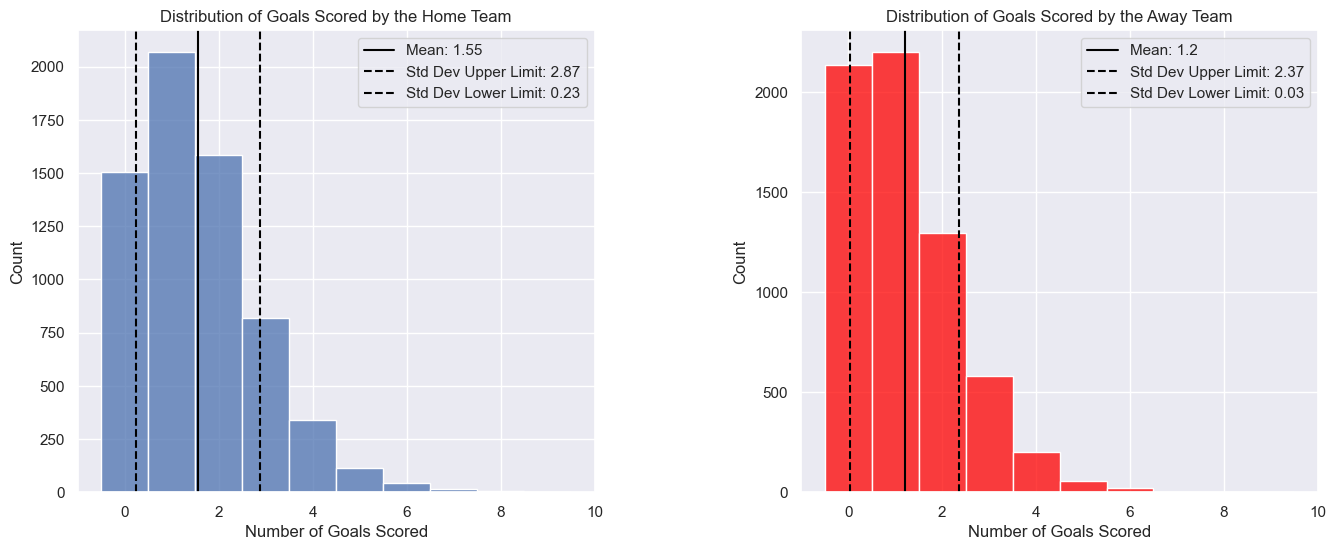

In [23]:
home_goals_mean = results_df.home_goals.mean()
home_goals_mean = round(home_goals_mean, 2)

away_goals_mean = results_df.away_goals.mean()
away_goals_mean = round(away_goals_mean, 2)

home_goals_std_dev = results_df.home_goals.std()
home_goals_std_dev = round(home_goals_std_dev, 2)
home_upper_limit = round((home_goals_std_dev + home_goals_mean), 2)
home_lower_limit = round((home_goals_mean - home_goals_std_dev), 2)

away_goals_std_dev = results_df.away_goals.std()
away_goals_std_dev = round(away_goals_std_dev, 2)
away_upper_limit = round((away_goals_mean + away_goals_std_dev), 2)
away_lower_limit = round((away_goals_mean - away_goals_std_dev), 2)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.set_palette('colorblind')
sns.histplot(x='home_goals', data=results_df, discrete=True)
plt.axvline(home_goals_mean, color='black', label=f'Mean: {home_goals_mean}')
plt.axvline(home_upper_limit, color='black', linestyle='--', label=f'Std Dev Upper Limit: {home_upper_limit}')
plt.axvline(home_lower_limit, color='black', linestyle='--', label=f'Std Dev Lower Limit: {home_lower_limit}')
plt.xlabel('Number of Goals Scored')
plt.title("Distribution of Goals Scored by the Home Team")
plt.legend()

plt.subplot(1, 2, 2)
sns.set_palette('colorblind')
sns.histplot(x='away_goals', data=results_df, discrete=True, color='red')
plt.axvline(away_goals_mean, color='black', label=f'Mean: {away_goals_mean}')
plt.axvline(away_upper_limit, color='black', linestyle='--', label=f'Std Dev Upper Limit: {away_upper_limit}')
plt.axvline(away_lower_limit, color='black', linestyle='--', label=f'Std Dev Lower Limit: {away_lower_limit}')
plt.xlabel('Number of Goals Scored')
plt.title("Distribution of Goals Scored by the Away Team")
plt.legend()

plt.subplots_adjust(wspace=0.4)

plt.show()

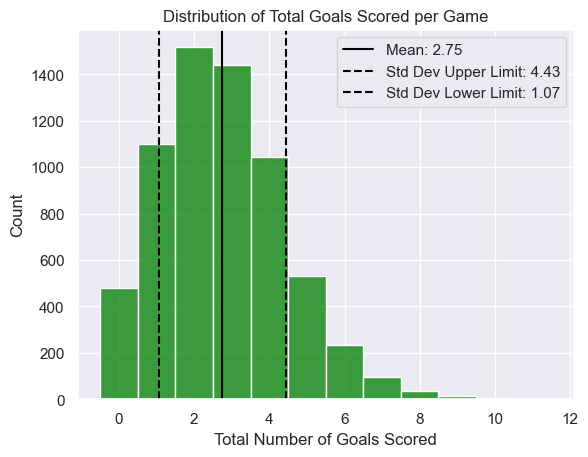

In [24]:
total_goals_mean = results_df.total_goals.mean()
total_goals_mean = round(total_goals_mean, 2)

total_std_dev = results_df.total_goals.std()
total_std_dev = round(total_std_dev, 2)
upper_limit = round((total_goals_mean + total_std_dev), 2)
lower_limit = round((total_goals_mean - total_std_dev), 2)

sns.set_palette('colorblind')
sns.histplot(x='total_goals', data=results_df, discrete=True, color='green')
plt.axvline(total_goals_mean, color='black', label=f'Mean: {total_goals_mean}')
plt.axvline(upper_limit, color='black', linestyle='--', label=f'Std Dev Upper Limit: {upper_limit}')
plt.axvline(lower_limit, color='black', linestyle='--', label=f'Std Dev Lower Limit: {lower_limit}')
plt.xlabel('Total Number of Goals Scored')
plt.title("Distribution of Total Goals Scored per Game")
plt.legend()

plt.show()

#### A Few Insights

We can see a few insightful things with these distribution plots. The first thing that I noticed was that the plot for the goals scored by the home team is noticeably different from the plot for the goals scored by the away team. We can see that, in general, the away team scores fewer goals than the home team. This makes sense intuitively but our plot gives us quantitative values that verify that logic. Later on we will explore this relationship in more detail to try to understand to what extent the location of a match affects the amount of goals a team might score.

We also took a look at the distribution for the total goals scored in each game. One conclusion we might draw from this plot is that it seems pretty rare to get a game with 0 goals scored. The majority of the games that occur will have at least 1 goal scored. It seems that most games will have between 2 to 3 goals.

I think one possible insight we can draw from all of this data could be this: Generally, we can expect that at least 1 goal will be scored in any Premier League match and the team that is most likely to score that goal would be the home team. We can also make some inferences about the defensive strength of particular teams. For example, if team A plays away vs team B, and the match ends 0 - 0, it might suggest that team A has a rather strong defense. This is because it would be rare for a game to not feature at least 1 goal from the home team. So we might infer that the away team, team A, needed to be strong defensively to create such an outcome.

#### Time Series Analysis

Next, let's take a look at some trends over time. Since we already took a look at some of the variables I want to stick with those for now. We can make line graphs that display the average goals scored by the home team, away team, and the average total goals scored per game. This can give us an idea about whether or not goals are mostly consistent over time or if trend in a particular direction.

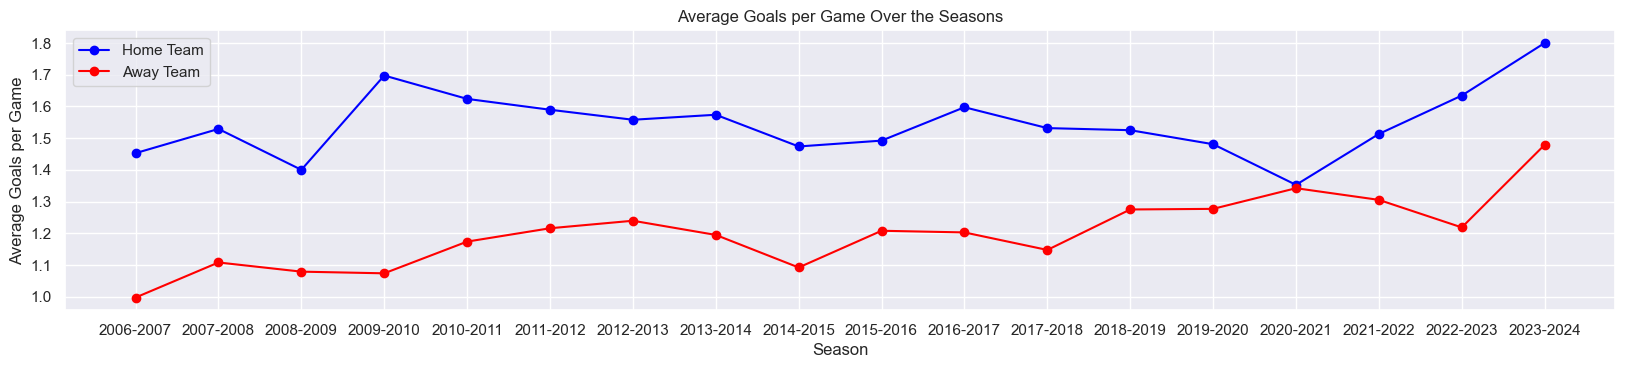

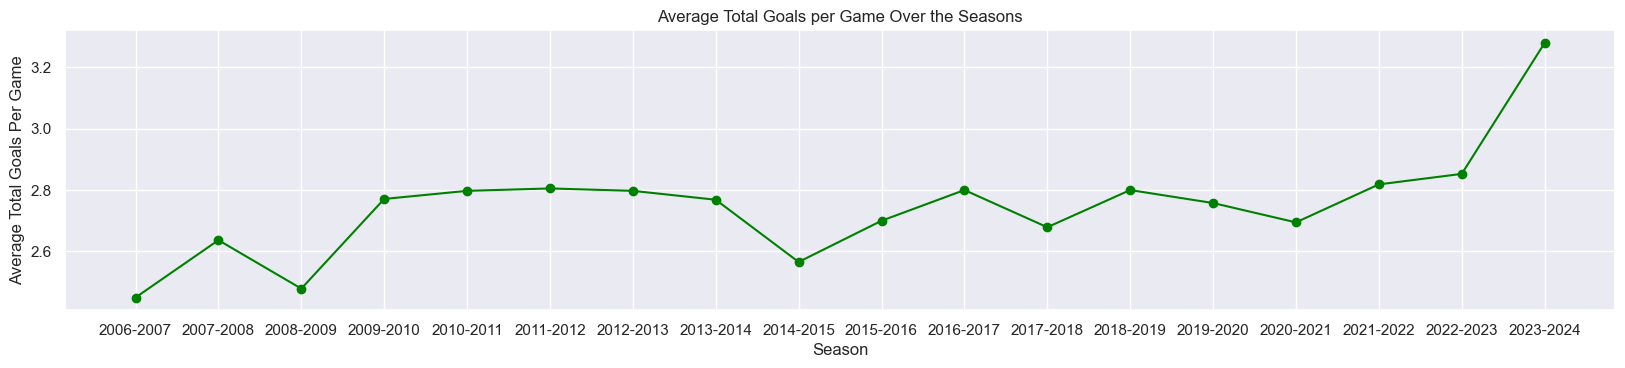

In [25]:
avg_total_goals_df = results_df.groupby("season", observed="False").total_goals.mean().reset_index()
avg_home_goals_df = results_df.groupby("season", observed="False").home_goals.mean().reset_index()
avg_away_goals_df = results_df.groupby("season", observed="False").away_goals.mean().reset_index()

plt.figure(figsize=(20, 8))

plt.subplot(2, 1, 1)
plt.plot(avg_home_goals_df.season, avg_home_goals_df.home_goals, color='blue', marker='o')
plt.plot(avg_away_goals_df.season, avg_away_goals_df.away_goals, color='red', marker='o')
plt.xlabel("Season")
plt.ylabel("Average Goals per Game")
plt.title("Average Goals per Game Over the Seasons")
plt.legend(['Home Team', 'Away Team'])
plt.show()

plt.figure(figsize=(20, 8))
plt.subplot(2, 1, 2)
plt.plot(avg_total_goals_df.season, avg_total_goals_df.total_goals, color='green', marker='o')
plt.xlabel("Season")
plt.ylabel("Average Total Goals Per Game")
plt.title("Average Total Goals per Game Over the Seasons")
plt.show()

## Key Insight!!

If you examine the plot showing the average goals scored by the home team and the away team, you may notice something interesting. During the 2020-2021 season, the home and away teams appeared to be much more evenly matched compared to other seasons. *This anomaly warrants further investigation!*

To understand what might have caused this, we need to consider any events or circumstances during that time period. This is where some Premier League knowledge becomes valuable. Any dedicated fan would recall that the 2020-2021 season was played in empty stadiums due to COVID-19. This provides a clear explanation for the unusual data point on the plot and strongly suggests that home fans do indeed provide an advantage to the home team. The absence of fans coincided with nearly even average goals scored by both teams.

This insight will be crucial in our next steps as we aim to build a simple model to predict game outcomes. Knowing that there is a significant advantage to playing at home, we can adjust the model's parameters to account for the match location.

We should also note that the most recent season was the highest-scoring season in terms of goals per game by far. This introduces a bit more uncertainty about the upcoming season. We might interpret this as a sign that the next season could also see more goals per game than many of the previous seasons. Alternatively, we might consider the 2023-2024 season an outlier and expect the 2024-2025 season to be more in line with previous seasons.

### Adding some new features

Part of the reason for creating this project in the first place was to establish a foundation on which I can build a predictive model for Premier League games. With this in mind, I want to create a few additional features. These features will use a formula to predict the number of goals a particular team might score against another. We will have many decisions to make when developing these features. Testing, experimenting, and adjusting them will be key to creating an effective predictive model.

To keep it brief for now, the features I want to create will use a mathematical formula based on each team's average goals scored and conceded at a particular location—home or away—to estimate the goals each team will score, thereby predicting the outcome of the match. I want to use a weighted average instead of a seasonal average for these predictions so I'm going to create those columns now.

Next, let's create a heatmap to visualize the correlation matrix for our numerical variables. This will help us identify which variables are most closely related.

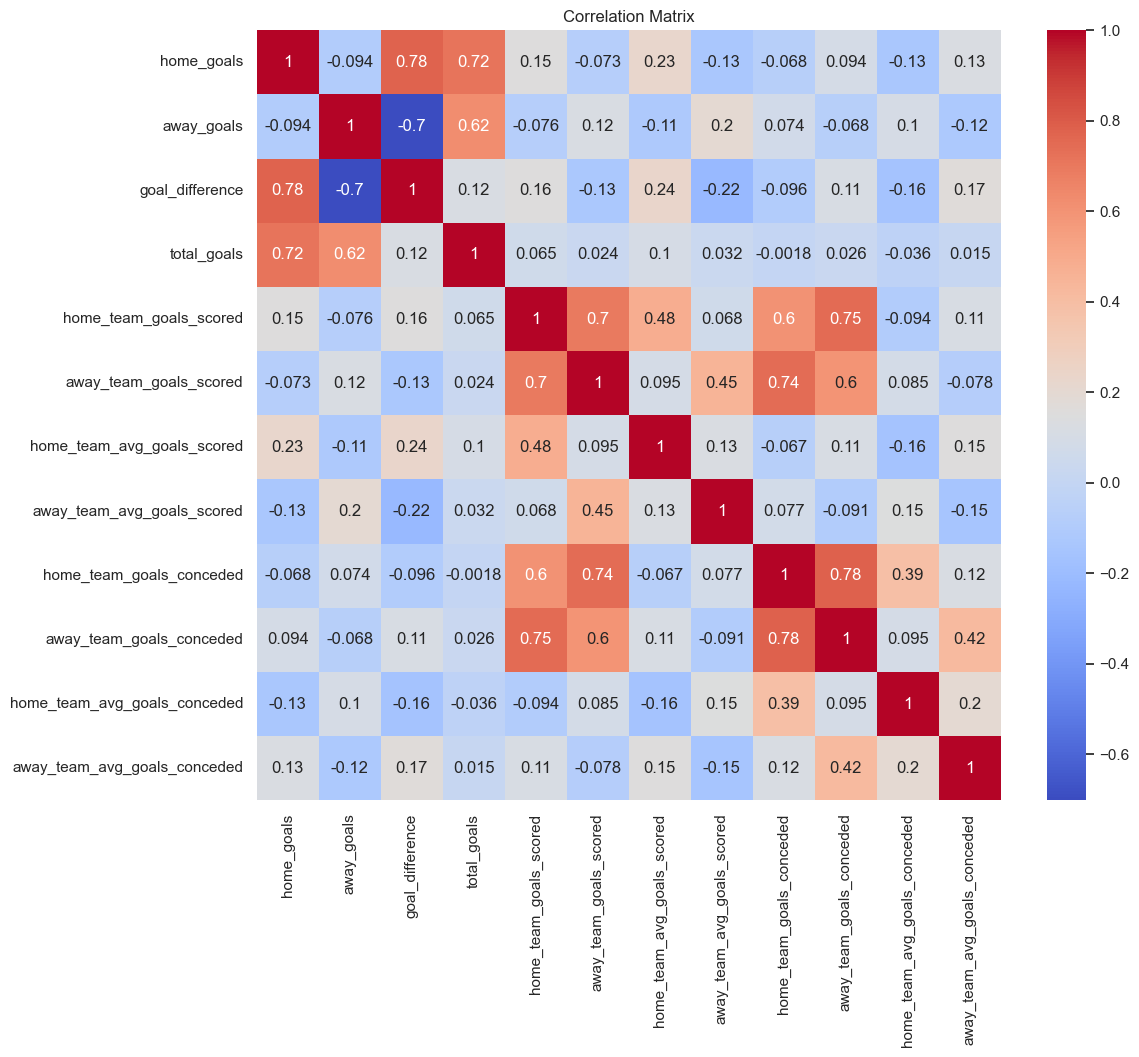

In [26]:
correlation_matrix = results_df[['home_goals', 'away_goals', 'goal_difference', 'total_goals', 'home_team_goals_scored',
                                 'away_team_goals_scored', 'home_team_avg_goals_scored', 'away_team_avg_goals_scored',
                                 'home_team_goals_conceded', 'away_team_goals_conceded', 'home_team_avg_goals_conceded', 'away_team_avg_goals_conceded']].corr()

plt.figure(figsize=(12, 10))
color_map = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, cmap=color_map)
plt.title("Correlation Matrix")
plt.show()

## What did we find out?

Looking at the correlation matrix reveals some interesting relationships. We want to focus on our goal here and that goal is predicting outcomes. So, the variable we really want to focus on is probably the *goal_difference* variable because if you can predict the goal difference of a game than you are essentially predicting the outcome. A positive goal difference for the home team would mean that they win the game, a neutral goal difference would indicate a tie, and a negative goal difference a loss.

The problem is that the relationship between the goal_difference variable and every other variable is not very strong. The best match we have seems to be the average goals scored by each team but the correlation coefficient value is only 0.24 which does not indicate a relationship between the variables. I want to create a weighted average for the teams goals scored and see if it has a stronger correlation with the goal difference.

In [27]:
results_df.tail(10)

,home_team,away_team,home_goals,away_goals,season,goal_difference,total_goals,result_away_win,result_draw,result_home_win,home_team_goals_scored,away_team_goals_scored,home_team_avg_goals_scored,away_team_avg_goals_scored,home_team_goals_conceded,away_team_goals_conceded,home_team_avg_goals_conceded,away_team_avg_goals_conceded
6490,Sheffield United,Tottenham Hotspur,0,3,2023-2024,-3,3,True,False,False,35,71,0.95,1.92,101,61,2.73,1.65
6491,Manchester City,West Ham United,3,1,2023-2024,2,4,False,False,True,93,59,2.51,1.59,33,71,0.89,1.92
6492,Luton Town,Fulham,2,4,2023-2024,-2,6,True,False,False,50,51,1.35,1.38,81,59,2.19,1.59
6493,Liverpool,Wolverhampton Wanderers,2,0,2023-2024,2,2,False,False,True,84,50,2.27,1.35,41,63,1.11,1.70
6494,Crystal Palace,Aston Villa,5,0,2023-2024,5,5,False,False,True,52,76,1.41,2.05,58,56,1.57,1.51
6495,Chelsea,Bournemouth,2,1,2023-2024,1,3,False,False,True,75,53,2.03,1.43,62,65,1.68,1.76
6496,Burnley,Nottingham Forest,1,2,2023-2024,-1,3,True,False,False,40,47,1.08,1.27,76,66,2.05,1.78
6497,Brighton and Hove Albion,Manchester United,0,2,2023-2024,-2,2,True,False,False,55,55,1.49,1.49,60,58,1.62,1.57
6498,Brentford,Newcastle United,2,4,2023-2024,-2,6,True,False,False,54,81,1.46,2.19,61,60,1.65,1.62
6499,Arsenal,Everton,2,1,2023-2024,1,3,False,False,True,89,39,2.41,1.05,28,49,0.76,1.32


In [28]:
def weighted_average(df, decay_factor=0.9):
    df = df.copy()
    df["home_team_weighted_average"] = 0.0
    df["away_team_weighted_average"] = 0.0

    for index in range(len(df)):
        home_team = df.iloc[index]['home_team']
        away_team = df.iloc[index]['away_team']

        temp_df = df.iloc[:index]  # Data up to (but not including) current match

        # For the home team
        team_matches = temp_df[(temp_df['home_team'] == home_team) | (temp_df['away_team'] == home_team)]

        if not team_matches.empty:
            # Get the goals scored by the home team in each match
            team_matches = team_matches.copy()
            team_matches['team_goals'] = np.where(
                team_matches['home_team'] == home_team,
                team_matches['home_goals'],
                team_matches['away_goals']
            )

            # Compute weights (exponentially decreasing weights)
            match_indices = team_matches.index.values
            weights = decay_factor ** (index - match_indices)

            # Compute weighted average
            weighted_goals = (team_matches['team_goals'] * weights).sum()
            total_weight = weights.sum()
            weighted_average = weighted_goals / total_weight

            df.at[index, 'home_team_weighted_average'] = round(weighted_average, 2)
        else:
            df.at[index, 'home_team_weighted_average'] = 0.0

        # For the away team
        team_matches = temp_df[(temp_df['home_team'] == away_team) | (temp_df['away_team'] == away_team)]

        if not team_matches.empty:
            team_matches = team_matches.copy()
            team_matches['team_goals'] = np.where(
                team_matches['home_team'] == away_team,
                team_matches['home_goals'],
                team_matches['away_goals']
            )

            # Compute weights
            match_indices = team_matches.index.values
            weights = decay_factor ** (index - match_indices)

            # Compute weighted average
            weighted_goals = (team_matches['team_goals'] * weights).sum()
            total_weight = weights.sum()
            weighted_average = weighted_goals / total_weight

            df.at[index, 'away_team_weighted_average'] = round(weighted_average, 2)
        else:
            df.at[index, 'away_team_weighted_average'] = 0.0

    return df


In [32]:
results_df = weighted_average(results_df, decay_factor=0.85)

In [33]:
results_df.tail(10)

,home_team,away_team,home_goals,away_goals,season,goal_difference,total_goals,result_away_win,result_draw,result_home_win,home_team_goals_scored,away_team_goals_scored,home_team_avg_goals_scored,away_team_avg_goals_scored,home_team_goals_conceded,away_team_goals_conceded,home_team_avg_goals_conceded,away_team_avg_goals_conceded,home_team_weighted_average,away_team_weighted_average
6490,Sheffield United,Tottenham Hotspur,0,3,2023-2024,-3,3,True,False,False,35,71,0.95,1.92,101,61,2.73,1.65,0.12,0.66
6491,Manchester City,West Ham United,3,1,2023-2024,2,4,False,False,True,93,59,2.51,1.59,33,71,0.89,1.92,2.52,1.97
6492,Luton Town,Fulham,2,4,2023-2024,-2,6,True,False,False,50,51,1.35,1.38,81,59,2.19,1.59,1.00,0.05
6493,Liverpool,Wolverhampton Wanderers,2,0,2023-2024,2,2,False,False,True,84,50,2.27,1.35,41,63,1.11,1.70,3.08,1.00
6494,Crystal Palace,Aston Villa,5,0,2023-2024,5,5,False,False,True,52,76,1.41,2.05,58,56,1.57,1.51,3.34,2.56
6495,Chelsea,Bournemouth,2,1,2023-2024,1,3,False,False,True,75,53,2.03,1.43,62,65,1.68,1.76,2.36,0.96
6496,Burnley,Nottingham Forest,1,2,2023-2024,-1,3,True,False,False,40,47,1.08,1.27,76,66,2.05,1.78,1.01,2.02
6497,Brighton and Hove Albion,Manchester United,0,2,2023-2024,-2,2,True,False,False,55,55,1.49,1.49,60,58,1.62,1.57,0.98,1.71
6498,Brentford,Newcastle United,2,4,2023-2024,-2,6,True,False,False,54,81,1.46,2.19,61,60,1.65,1.62,1.75,1.82
6499,Arsenal,Everton,2,1,2023-2024,1,3,False,False,True,89,39,2.41,1.05,28,49,0.76,1.32,1.28,1.01


We can see that we have different values for the weighted averages than we have for the seasonal ones. Lets go ahead and run the matrix again to see if this has a better relationship with our goal_difference variable.

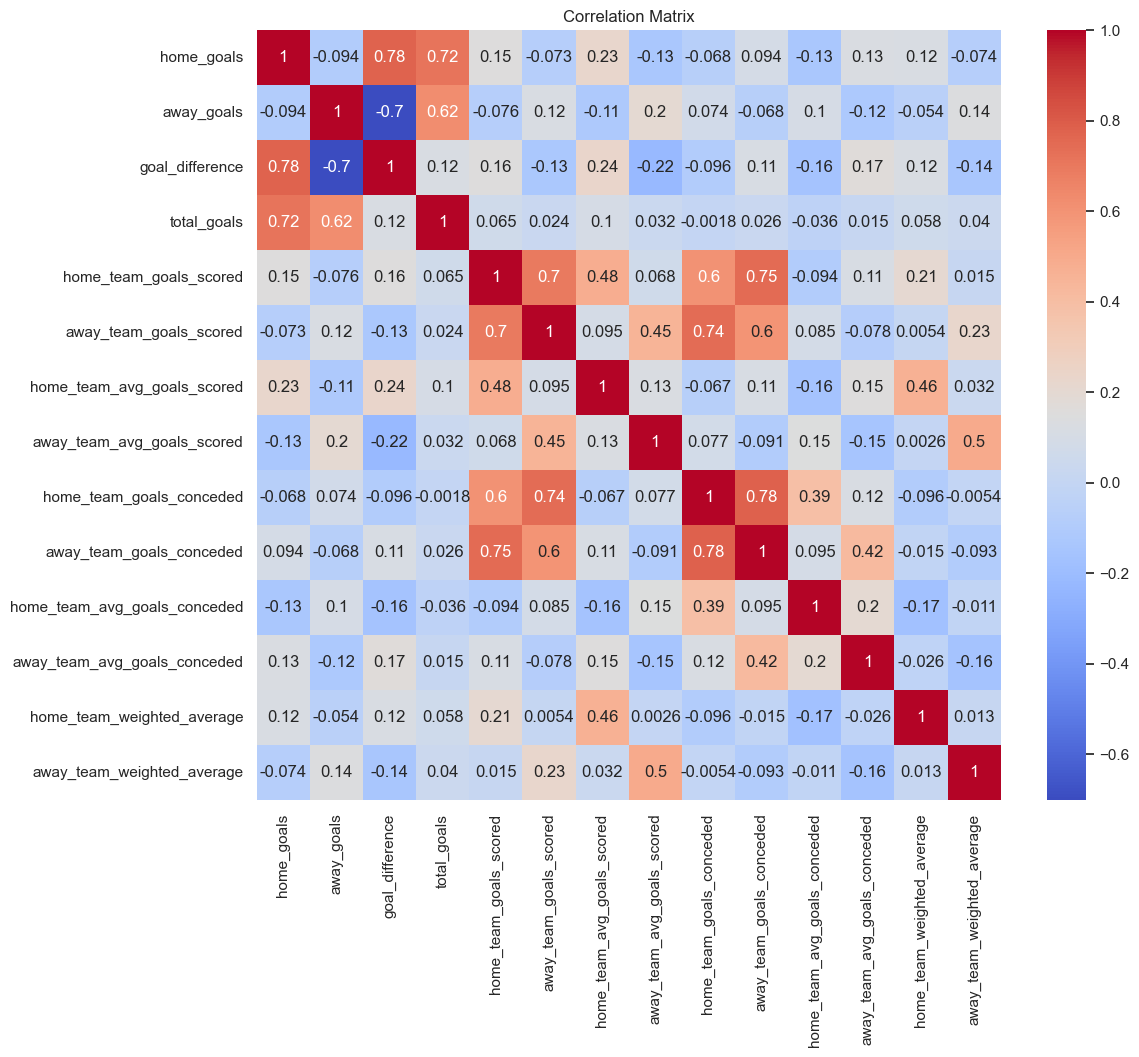

In [34]:
correlation_matrix = results_df[['home_goals', 'away_goals', 'goal_difference', 'total_goals', 'home_team_goals_scored',
                                 'away_team_goals_scored', 'home_team_avg_goals_scored', 'away_team_avg_goals_scored',
                                 'home_team_goals_conceded', 'away_team_goals_conceded', 'home_team_avg_goals_conceded', 'away_team_avg_goals_conceded', 'home_team_weighted_average', 'away_team_weighted_average']].corr()

plt.figure(figsize=(12, 10))
color_map = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, cmap=color_map)
plt.title("Correlation Matrix")
plt.show()

In [36]:
def predictor_column(df):
    df['home_goals_predicted'] = df.apply(lambda row: ((row['home_team_avg_goals_scored'] + row['away_team_avg_goals_conceded']) / 2), axis=1)
    df['away_goals_predicted'] = df.apply(lambda row: ((row['home_team_avg_goals_conceded'] + row['away_team_avg_goals_scored']) / 2), axis=1)
    return df

In [38]:
results_df = predictor_column(results_df)